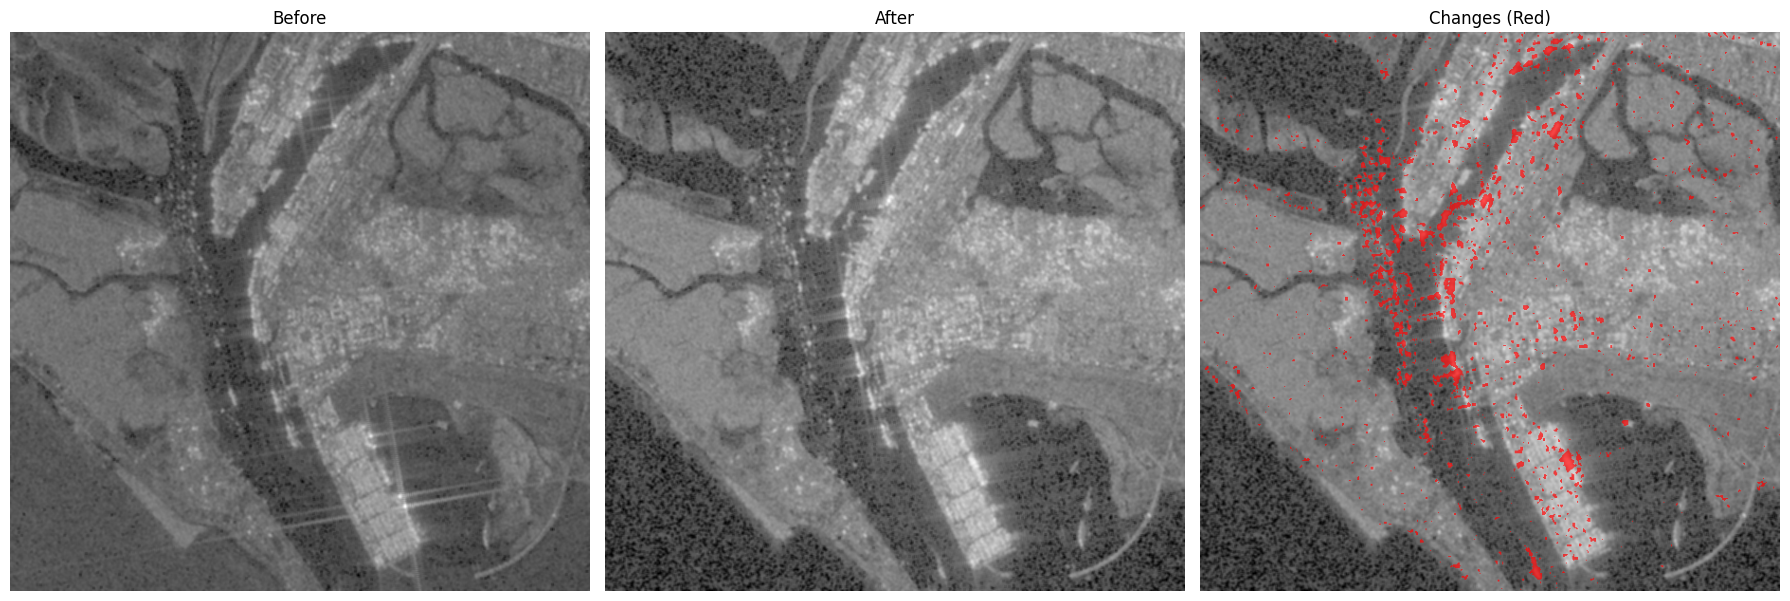

Saved changes as GeoJSON: E:\EO-SAR_change_detection\output\sen1\land_water_changes.geojson

Saved Land + Water Change Mask (TIFF) and GeoJSON to: E:\EO-SAR_change_detection\output\sen1


e:\EO-SAR_change_detection\eo_sar_env\Lib\site-packages\pyogrio\geopandas.py:710: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  write(


In [ ]:
import os
import numpy as np
import rasterio
from rasterio.features import shapes
from skimage.measure import label, regionprops
from scipy.ndimage import binary_opening, binary_closing, generate_binary_structure, uniform_filter
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import shape

# --------------------------------------------------------
# USER PARAMETERS (EDIT PATHS)
# --------------------------------------------------------
PATH_T1 = r"PATH_TO_PRE_EVENT_SAR.tif"    # e.g., "data/pre_event.tif"
PATH_T2 = r"PATH_TO_POST_EVENT_SAR.tif"   # e.g., "data/post_event.tif"
OUT_FOLDER = r"OUTPUT_FOLDER_PATH"        # e.g., "output"

MIN_AREA = 10                    # Minimum connected-pixel area
EPS = 1e-9
PERCENTILE_OBJ = 95              # Object-level changes
PERCENTILE_PIX = 90              # Pixel-level land changes
PERCENTILE_WATER = 98            # Pixel-level water changes
MIN_BACKSCATTER_DB = -20         # Water threshold in dB

os.makedirs(OUT_FOLDER, exist_ok=True)

# --------------------------------------------------------
# HELPER FUNCTIONS
# --------------------------------------------------------
def read_raster(path):
    with rasterio.open(path) as src:
        arr = src.read(1).astype(np.float32)
        profile = src.profile
    return arr, profile

def to_db(img):
    img = np.clip(img, EPS, None)
    return 10 * np.log10(img)

def despeckle(img, size=3):
    return uniform_filter(img, size=size)

def clean_mask(mask, min_area=MIN_AREA):
    struct = generate_binary_structure(2, 2)
    mask = binary_opening(mask, structure=struct)
    mask = binary_closing(mask, structure=struct)
    labeled = label(mask)
    cleaned = np.zeros_like(mask, dtype=np.uint8)
    for reg in regionprops(labeled):
        if reg.area >= min_area:
            cleaned[tuple(zip(*reg.coords))] = 1
    return cleaned

def save_mask(path, mask, profile):
    profile_out = profile.copy()
    profile_out.update(dtype=rasterio.uint8, count=1, compress="lzw")
    with rasterio.open(path, "w", **profile_out) as dst:
        dst.write(mask.astype(np.uint8), 1)

def mask_to_geojson(mask, profile, out_path, min_area=MIN_AREA):
    shp_gen = shapes(mask.astype(np.uint8), mask=mask.astype(bool), transform=profile["transform"])
    polygons = [shape(geom) for geom, val in shp_gen if val == 1]
    pixel_area = abs(profile['transform'][0] * profile['transform'][4])
    polygons = [poly for poly in polygons if poly.area >= min_area * pixel_area]
    if not polygons:
        print("No change polygons detected.")
        return
    gdf = gpd.GeoDataFrame({"geometry": polygons}, crs=profile["crs"])
    gdf.to_file(out_path, driver="GeoJSON")
    print("GeoJSON saved:", out_path)

# --------------------------------------------------------
# MAIN WORKFLOW
# --------------------------------------------------------
# Read SAR images
img1, prof1 = read_raster(PATH_T1)
img2, prof2 = read_raster(PATH_T2)
if img1.shape != img2.shape:
    raise ValueError("Input rasters must have identical dimensions.")

# Convert to dB and despeckle
db1 = despeckle(to_db(img1))
db2 = despeckle(to_db(img2))

# Land/Water separation
water_mask = (db1 < MIN_BACKSCATTER_DB) & (db2 < MIN_BACKSCATTER_DB)
land_mask = ~water_mask

# ---------------------------
# LAND CHANGE DETECTION
# ---------------------------
abs_diff = np.abs(db2 - db1) * land_mask
thr1 = np.percentile(db1[land_mask], PERCENTILE_OBJ)
thr2 = np.percentile(db2[land_mask], PERCENTILE_OBJ)
mask1 = clean_mask(db1 >= thr1)
mask2 = clean_mask(db2 >= thr2)
labeled1 = label(mask1)
labeled2 = label(mask2)

change_land_obj = np.zeros_like(db1, dtype=np.uint8)
for reg in regionprops(labeled2):
    coords = reg.coords
    if np.all(labeled1[coords[:,0], coords[:,1]] == 0):
        change_land_obj[coords[:,0], coords[:,1]] = 1
for reg in regionprops(labeled1):
    coords = reg.coords
    if np.all(labeled2[coords[:,0], coords[:,1]] == 0):
        change_land_obj[coords[:,0], coords[:,1]] = 1

thr_intensity = np.percentile(abs_diff[land_mask], PERCENTILE_OBJ)
for reg in regionprops(labeled1):
    coords = reg.coords
    m1 = db1[coords[:,0], coords[:,1]].mean()
    m2 = db2[coords[:,0], coords[:,1]].mean()
    if abs(m2 - m1) >= thr_intensity:
        change_land_obj[coords[:,0], coords[:,1]] = 1

change_land_obj = clean_mask(change_land_obj)

bright_diff = (db2 - db1).clip(min=0) * land_mask
thr_pix = np.percentile(bright_diff[bright_diff > 0], PERCENTILE_PIX)
change_land_pix = bright_diff >= thr_pix
change_land = np.logical_or(change_land_obj, change_land_pix)

# ---------------------------
# WATER CHANGE DETECTION
# ---------------------------
bright_water = (db2 - db1).clip(min=0) * water_mask
thr_water = np.percentile(bright_water[bright_water > 0], PERCENTILE_WATER)
change_water = clean_mask(bright_water >= thr_water)

# ---------------------------
# FINAL MASK MERGE
# ---------------------------
final_mask = np.logical_or(change_land, change_water).astype(np.uint8)

# ---------------------------
# VISUALIZATION
# ---------------------------
norm_after = (db2 - db2.min()) / (db2.max() - db2.min() + EPS)
overlay = np.stack([norm_after]*3, axis=2)
overlay[final_mask==1] = [1, 0, 0]

fig, ax = plt.subplots(1,3, figsize=(18,6))
ax[0].imshow(db1, cmap="gray"); ax[0].set_title("Before"); ax[0].axis("off")
ax[1].imshow(db2, cmap="gray"); ax[1].set_title("After"); ax[1].axis("off")
ax[2].imshow(norm_after, cmap="gray")
ax[2].imshow(overlay, alpha=0.7)
ax[2].set_title("Detected Changes (Red)"); ax[2].axis("off")
plt.tight_layout()
plt.savefig(os.path.join(OUT_FOLDER, "change_visualization.png"), dpi=200)
plt.close()

# ---------------------------
# SAVE RESULTS
# ---------------------------
save_mask(os.path.join(OUT_FOLDER, "change_mask.tif"), final_mask, prof2)
geojson_file = os.path.join(OUT_FOLDER, "change_polygons.geojson")
mask_to_geojson(final_mask, prof2, geojson_file)

print("\nChange detection completed successfully.")
print("Output folder:", OUT_FOLDER)